<a href="https://colab.research.google.com/github/ola-sumbo/knowledge-graph-recommender/blob/master/Content_Recommender_system_with_Network_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving AI_scopus.csv to AI_scopus (1).csv


In [15]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [17]:
# import scopus
scopus_data = pd.read_csv("AI_scopus.csv")
scopus_data.shape

(1387, 30)

In [18]:
scopus_data['Authors with affiliations'].sample(5)

1063    Patil, H.A., Dhirubahi Ambani Institute of Information and Communication Technology (DA-IICT), Gandhinagar, Gujarat, India; Basu, T.K., Department of Electrical Engineering, IIT Kharagpur, W. Beng...
527                              Kanaujia, A., ObjectVideo, Inc., India; Haering, N., ObjectVideo, Inc., India; Taylor, G., New York University, United States; Bregler, C., New York University, United States
28      Ramaswamy, H.G., Department of Computer Science and Automation, Indian Institute of Science, Bangalore, India; Agarwal, S., Department of Computer Science and Automation, Indian Institute of Scien...
1284    Ramesh, D., Department of Electronics and Communication Engineering, Indian Institute of Technology, Guwahati, India; Ghosh, D., Department of Electronics and Communication Engineering, Indian Ins...
932     Praseeda Lekshmi, V., College of Engineering Kidangoor, Kottayam, Kerala, India; Sasikumar, M., Marian Engineering College Trivandrum, Kerala, India; Vidyadhara

In [19]:
scopus_data['Abstract'].sample(5)

1381    Blind source separation of acoustic mixtures aims at providing a solution to the classical cocktail-party problem. The inherent delays and convolutions in microphone recordings, entails a modifica...
621     Although there have been many recent studies of link prediction in co-authorship networks, few have tried to utilize the Semantic information hidden in abstracts of the research documents. We prop...
1027    The dynamics of Hopfield Neural Network (HNN) as a point attractor for the cloud classes has been presented. Raw binary data collected over the Indian region from the five microwave channels of th...
769     Water quality management though a very important part of overall water resources management programs is also unfortunately given the last priority among all the other objectives like water supply ...
948     Clustering accuracy of partitional clustering algorithm for categorical data primarily depends upon the choice of initial data points (modes) to instigate the c

**Define function to extract parts of speech**

In [20]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [21]:
entity_pairs = []

for i in tqdm(scopus_data["Abstract"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 1387/1387 [01:31<00:00, 15.21it/s]


In [22]:
# view entity pairs breakdown
entity_pairs[10:20]

[['based  descriptor', 'frontal face FERET'],
 ['Also  we', 'better  results'],
 ['malicious source identification audio', 'unauthorized  source'],
 ['proposed membership function it', 'embedded  system'],
 ['Hence  simulations', 'desired performance results'],
 ['comparative  results', 'paper'],
 ['work', 'digital research content'],
 ['experimental processing results', 'proposed imperceptibility criteria'],
 ['empirical  study', 'technical cloud education'],
 ['proposed technique We', 'skin tone']]

In [23]:
authors_pairs = []
for i in tqdm(scopus_data["Authors with affiliations"]):
  authors_pairs.append(get_entities(i))

100%|██████████| 1387/1387 [01:05<00:00, 21.23it/s]


In [24]:
authors_pairs[10:20]

[['', ''],
 ['', 'Datta Meghe Engineering'],
 ['', ''],
 ['', 'K.P. Zakir Husain Engineering'],
 ['', 'Electronics Computer Technology'],
 ['', 'IT'],
 ['', ''],
 ['', ''],
 ['', 'N. Vivekananda Technology'],
 ['', 'N Shetty Technology']]

In [25]:
title_pairs = []
for i in tqdm(scopus_data["Title"]):
  title_pairs.append(get_entities(i))

100%|██████████| 1387/1387 [00:55<00:00, 24.96it/s]


In [26]:
title_pairs[10:20]

[['', 'binary gender classification'],
 ['', 'Decision training'],
 ['Tamper  detection', 'access control systems'],
 ['CMOS', 'fuzzy logic controller applications'],
 ['', 'improved R AODV MANETs'],
 ['', 'reactive netsim simulator'],
 ['', 'digital  image'],
 ['', 'audio copyright protection'],
 ['', 'technical cloud education'],
 ['', 'human mouth face']]

**Predicate Extraction: Removing the main verb from the sentence**

In [28]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [29]:
relations = [get_relation(i) for i in tqdm(scopus_data['Abstract'])]

100%|██████████| 1387/1387 [01:41<00:00, 13.72it/s]


In [30]:
pd.Series(relations).value_counts()[:50]

IICAI                   253
IEEE                    225
©                       139
reserved                 62
Association for          60
show                     36
is                       28
Copyright                27
demonstrate              25
University               25
shows                    17
found                    14
shown                    10
ACL                       7
indicate                  7
presented                 7
demonstrated              6
confirm                   6
compare                   6
observed                  6
present                   5
report                    5
compared with             5
Agarwal                   5
extend                    4
used for                  4
provides                  4
suggest                   4
available                 4
discussed                 4
used                      4
makes                     4
reveals                   3
achieved                  3
outperforms               3
reveal              

**Using relation function on title**

In [31]:
rel_one = [get_relation(i) for i in tqdm(scopus_data['Title'])]

100%|██████████| 1387/1387 [01:09<00:00, 20.00it/s]


In [32]:
pd.Series(rel_one).value_counts()[:50]

approach                 31
based                    27
approach for             25
On                       23
algorithm for            18
model for                15
recognition              15
system                   13
Face                     11
detection                11
system for               10
Learning                 10
classification           10
learning                  9
Improving                 9
algorithm                 8
method for                7
segmentation              7
Analysis of               7
study of                  6
identification            6
using                     6
approach to               6
framework for             5
Design                    5
analysis of               5
Classification of         5
networks                  5
Application of            5
Estimating                5
modeling                  5
Development of            5
Application of neural     5
Using                     4
Design of                 4
learning of         

**Extracting Subject and Object in Abstract**

In [33]:
# extract subject
source = [i[0] for i in entity_pairs] 

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [34]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

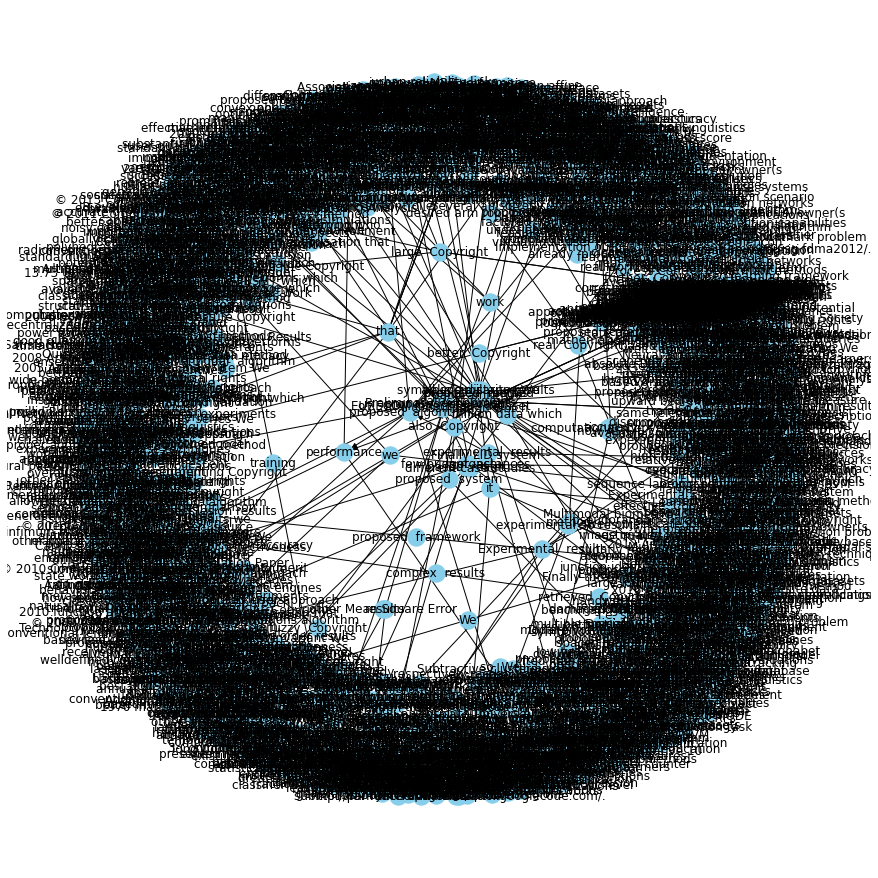

In [35]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

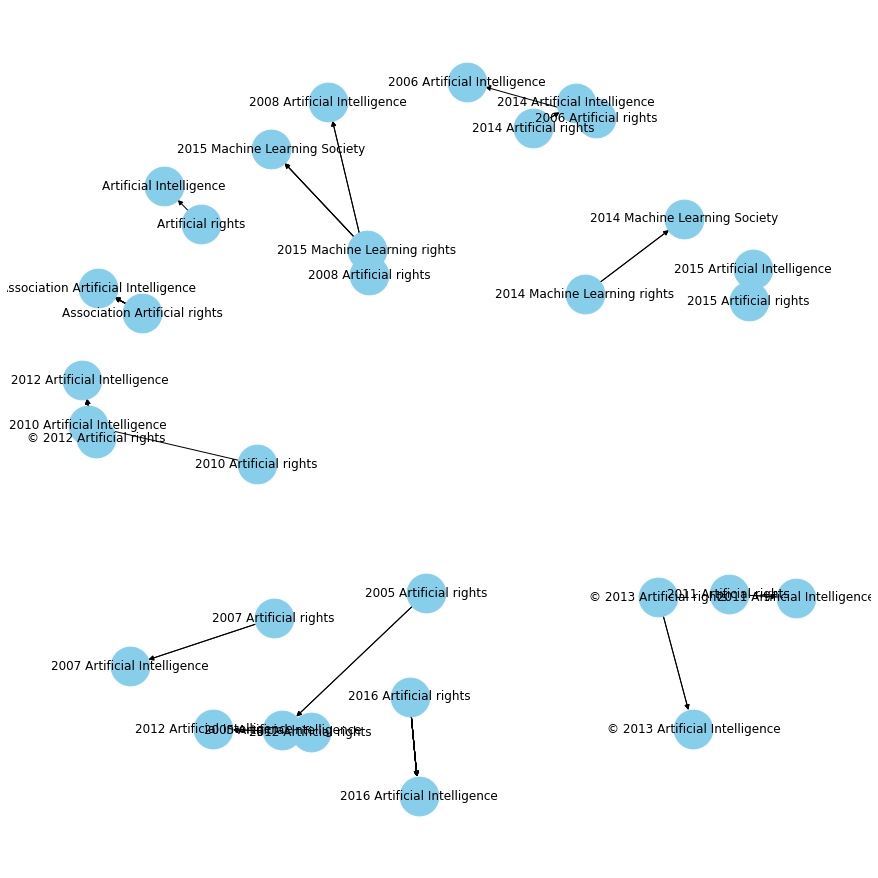

In [38]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="reserved"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

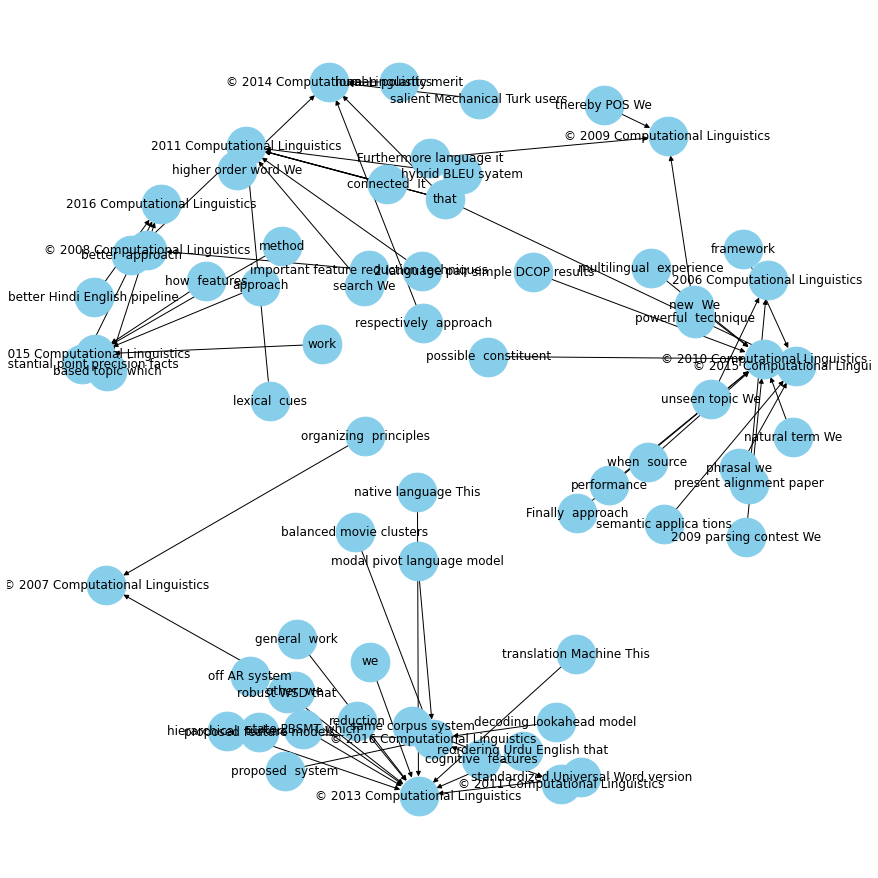

In [39]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Association for"], "source", "target",edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()  # so we see that computational linguistic consistently increased its work from 2006 until 2016. It had more research done in the year 2013.


**Title**

In [40]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':rel_one})

In [41]:
# create a directed-graph from a dataframe
T=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

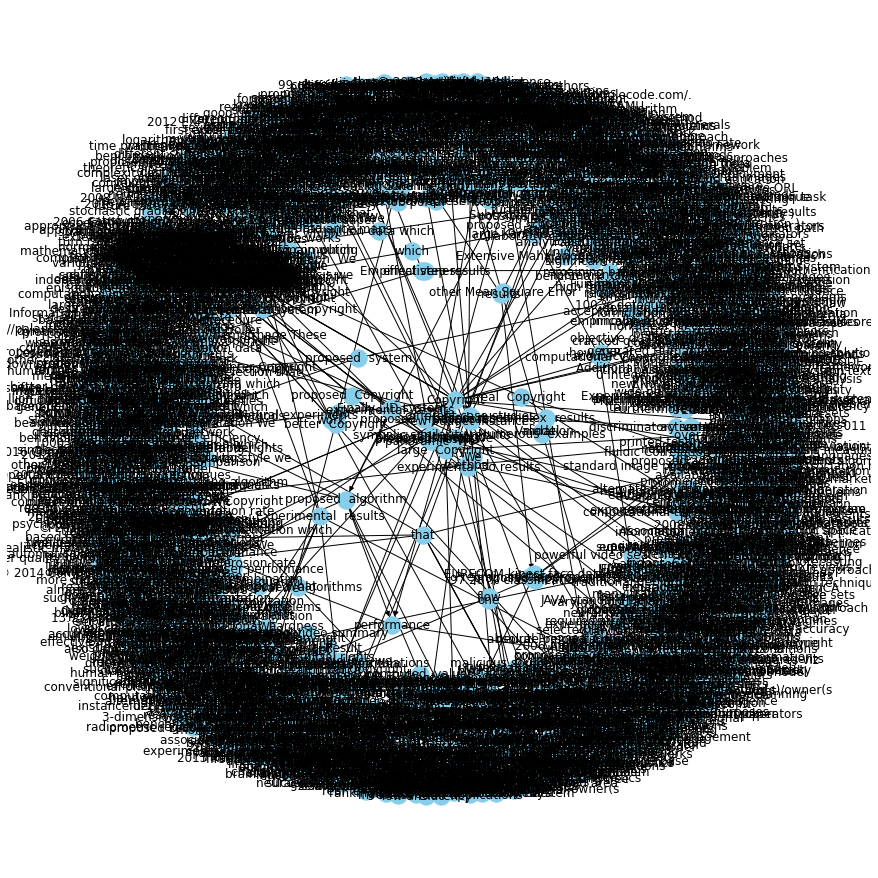

In [44]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(T)
nx.draw(T, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

**Peeking at Algorith and Approach**

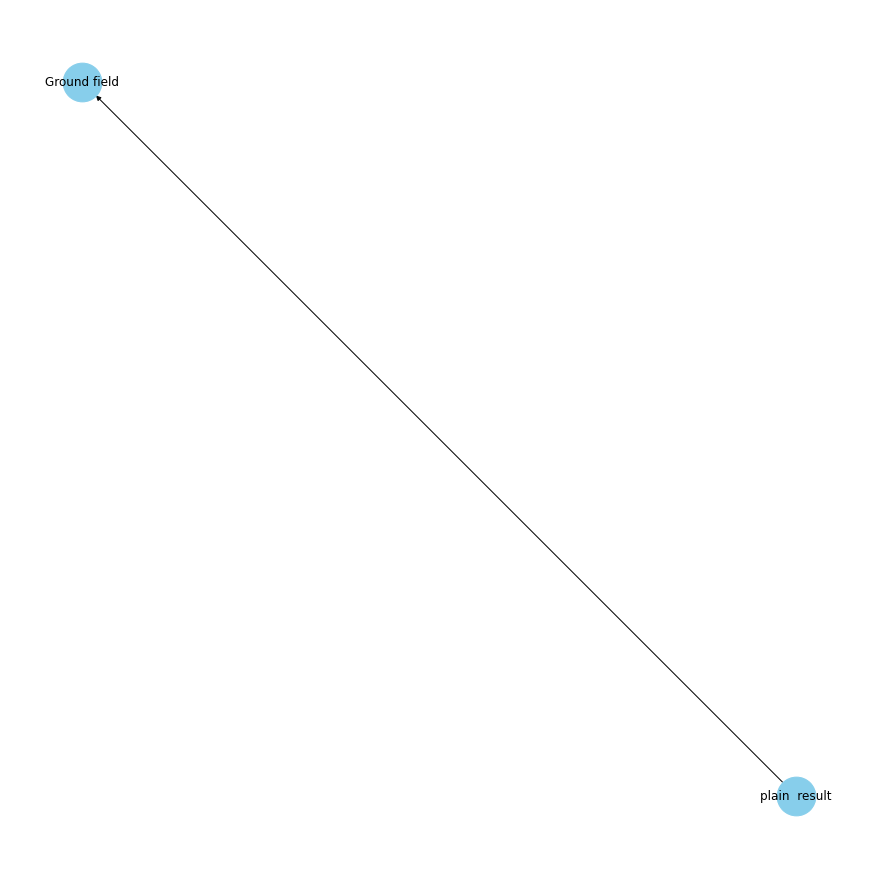

In [45]:
T=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Approach"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(T, k = 0.5) # k regulates the distance between nodes
nx.draw(T, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show() # This knowledge graph tells us there only two approaches in our data set ie Ground field and plain result

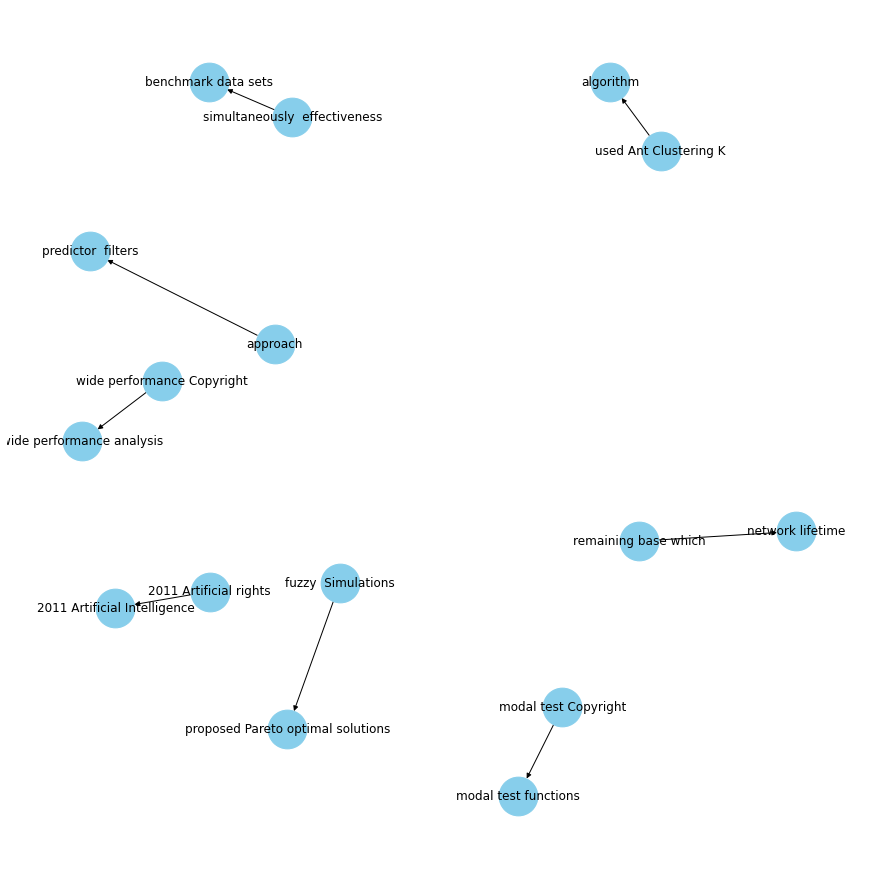

In [47]:
T=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="algorithm"], "source", "target",edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(T, k = 0.5)
nx.draw(T, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show() # algorithm for is mostly used for stock market & association rules (apriori), whereas algorithm used is ant clustering

**Authors**

In [52]:
author_relations = [get_relation(i) for i in tqdm(scopus_data['Authors with affiliations'])]

100%|██████████| 1387/1387 [01:20<00:00, 17.23it/s]


In [53]:
pd.Series(author_relations).value_counts()[:50]

India            58
Kumar            26
Jain             23
Singh            21
.                15
College of       14
Das              13
Gupta            13
Srivastava       12
Sharma           11
Mishra           11
Agarwal          10
University       10
Pandey            9
Rao               8
Institute of      8
Agrawal           8
Department of     8
Bangalore         8
Sinha             8
Bhattacharyya     7
Verma             7
College           7
Joshi             6
Ray               6
Ramaswamy         6
Babu              6
Bedi              6
Sarkar            6
Guru              6
Mohan             6
Narasimhan        6
Anand             5
Ghoshdastidar     5
Varma             5
Dey               5
Nain              5
Kanpur            5
Ghosh             5
Mukherjee         5
Kar               5
Natarajan         4
Ijjina            4
Sarkhel           4
Chandra           4
Bhattacharya      4
Rajkumar          4
Kolkata           4
Somasundaram      4
Maji              4


In [54]:
# extract subject
source = [i[0] for i in entity_pairs] 

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':author_relations})

In [55]:
# create a directed-graph from a dataframe
A=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

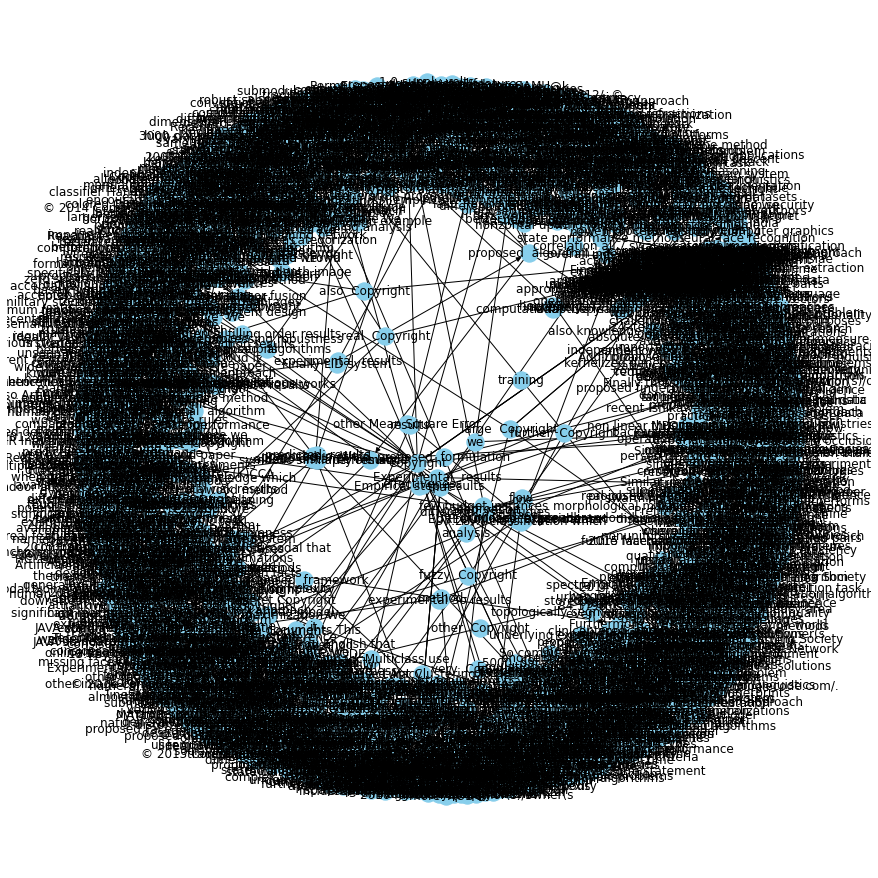

In [56]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(A)
nx.draw(A, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [57]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':author_relations})

**Kumar is the second notable author after india so we will look see**

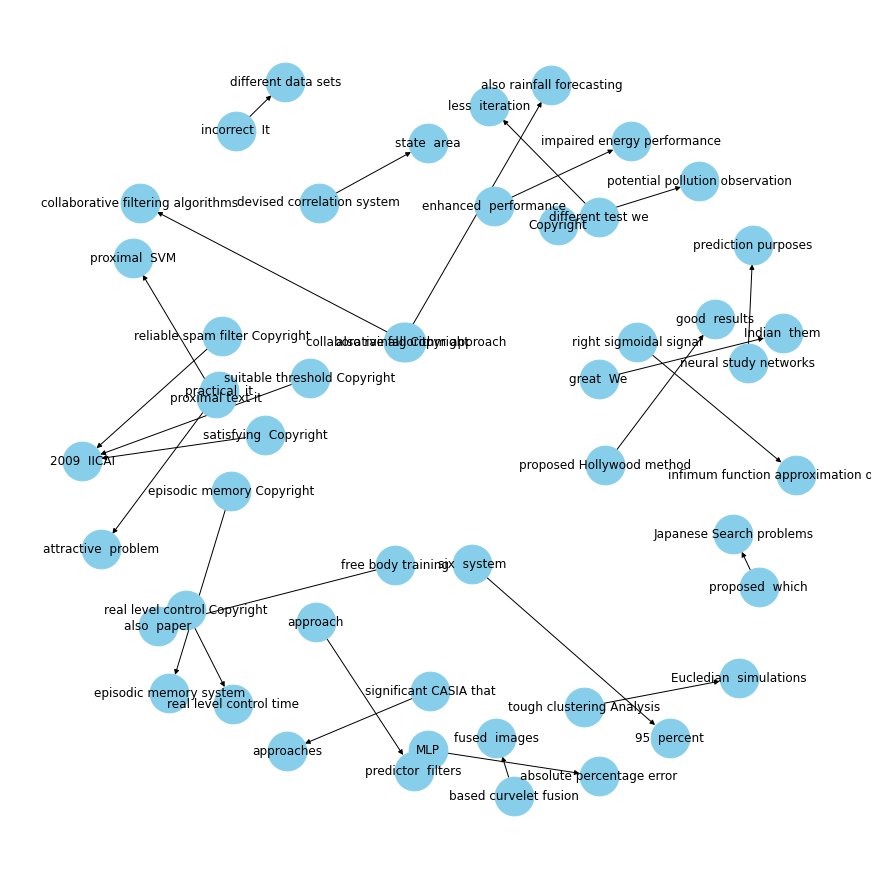

In [58]:
A=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Kumar"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(A, k = 0.5) # k regulates the distance between nodes
nx.draw(A, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show() # This knowledge graph tells us there only two approaches in our data set ie Ground field and plain result